In [40]:
import argparse
import itertools
import math
import textwrap
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as sla
from scipy.spatial.distance import cdist

import numpy as np
import time
import tntorch as tn
import torch
torch.set_default_dtype(torch.float64)

In [29]:
def reconstruct(A, G, axes=([-1], [0])):
    A_hat = G[0]
    for c in G[1:]:
        if c.ndim == 1:  # only for SVD!
            c = sla.diagsvd(c, c.shape[0], c.shape[0])

        A_hat = np.tensordot(A_hat, c, axes=axes)

    err = sla.norm((A - A_hat).ravel()) / sla.norm(A.ravel())
    compression_rate = int(A.size / sum(g.size for g in G))

    return A_hat, err, compression_rate

In [20]:
def tt_svd(A, eps=0.05, ax=None):
    """
    https://sites.pitt.edu/~sjh95/related_papers/tensor_train_decomposition.pdf
    Algorithm 1: TT-svd
    """

    d = A.ndim
    A_norm = sla.norm(A.ravel())
    eps_A = eps * A_norm
    delta = eps_A / math.sqrt(d - 1)

    C = A.copy()
    r0 = 1

    G = []
    for i, nk in enumerate(A.shape[:-1]):
        C = C.reshape(r0 * nk, -1)

        U, s, Vh = sla.svd(C, full_matrices=False)
        if ax is not None:
            ax.plot(
                s,
                label=f"$C_{i}$ {C.shape[0]}x{C.shape[1]}: {s.shape[0]} singular values",
            )
            ax.set_yscale("log")

        S = sla.diagsvd(s, Vh.shape[0], Vh.shape[0])

        rk = 1
        while True:
            err = sla.norm((C - U[:, :rk] @ (S @ Vh)[:rk]).ravel())
            if err >= delta:
                rk += 1
                print(
                    f"Not enough precision for TT-SVD {err}."
                    f"The number of singular values  is increased to {rk}!"
                )
            else:
                break

        G.append(U[:, :rk].reshape(r0, nk, rk))
        C = (S @ Vh)[:rk]

        r0 = rk

    if ax is not None:
        ax.set_title(f"singular values TT-SVD ({A.shape})")
        ax.grid(ls="--")
        ax.legend()

    G.append(C)

    A_hat, err, compression_rate = reconstruct(A, G)
    assert err < eps_A, f"Not enough precision ({err}). Increase the number of singluar values!"

    return A_hat, G, err, compression_rate

In [23]:
def get_label(method, G, err, cr):
    label = (
        f"{method}"
        f", err:{err:.3} cr:{cr}"
        f", {','.join('x'.join(map(str, g.shape)) for g in G)}"
    )

    return label

In [46]:
def metrics(full, t):
    print(t)
    print('Compression ratio: {}/{} = {:g}'.format(full.numel(), t.numcoef(), full.numel() / t.numcoef()))
    print('Relative error:', tn.relative_error(full, t))
    print('RMSE:', tn.rmse(full, t))
    print('R^2:', tn.r_squared(full, t))

In [83]:
N = 10332
tol = 0.01
x = pd.read_csv('BOE-XUDLNKG.csv', usecols=['Value'], nrows=N)
x = x.dropna()
N = len(x)
x = x.values.ravel()[:N]
n1, n2, n3 = 41, 18, 14
X = x.reshape(n1, n2, n3)
full = torch.Tensor(X)

In [84]:
tt_torch = tn.Tensor(full, ranks_tt=3)
metrics(full, tt_torch)

3D TT tensor:

 41  18  14
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   3   3   1

Compression ratio: 10332/327 = 31.5963
Relative error: tensor(0.0097)
RMSE: tensor(1.0082)
R^2: tensor(0.9866)


In [85]:
tucker_torch = tn.Tensor(full, ranks_tucker=3)
metrics(full, tucker_torch)

3D TT-Tucker tensor:

 41  18  14
  |   |   |
  3   3   3
 (0) (1) (2)
 / \ / \ / \
1   9   3   1

Compression ratio: 10332/336 = 30.75
Relative error: tensor(0.0098)
RMSE: tensor(1.0199)
R^2: tensor(0.9863)


In [87]:
CP_torch = tn.Tensor(full, ranks_cp=3, verbose=True)
metrics(full, CP_torch)

ALS -- initialization time = 0.00942683219909668
iter: 0  | eps: 0.02065839 | total time:    0.0123
iter: 1  | eps: 0.01023783 | total time:    0.0133
iter: 2  | eps: 0.00986777 | total time:    0.0143
iter: 3  | eps: 0.00986269 | total time:    0.0153 <- converged (tol=0.0001)
3D CP tensor:

 41  18  14
  |   |   |
 <0> <1> <2>
 / \ / \ / \
3   3   3   3

Compression ratio: 10332/219 = 47.1781
Relative error: tensor(0.0099)
RMSE: tensor(1.0244)
R^2: tensor(0.9862)


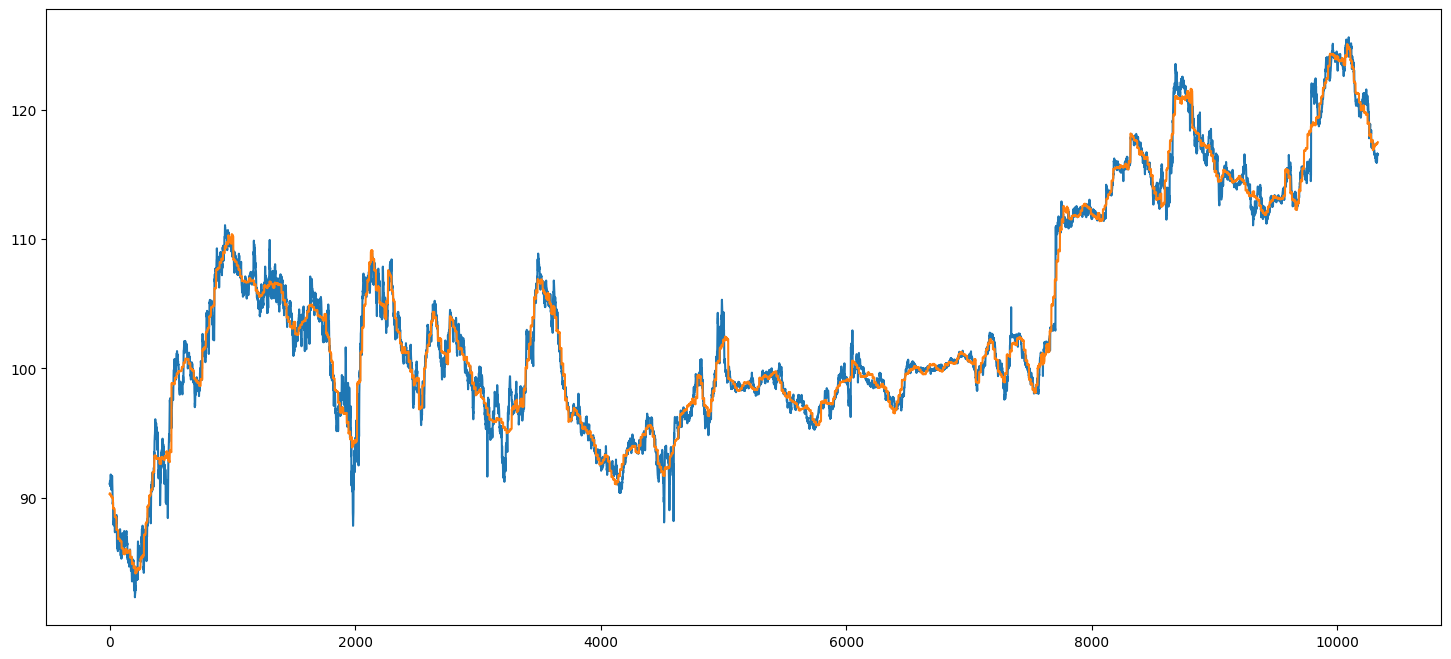

In [88]:
mosaic = textwrap.dedent(
    '''
        ddd
        '''
)
fig, axes = plt.subplot_mosaic(mosaic, figsize=(18, 8))

axes["d"].plot(x, label='x')

# X_tt, G_tt, error_tt, cr_tt = tt_svd(X, eps=tol)
# x_tt = X_tt.reshape(-1)
# axes["d"].plot(x_tt, label=get_label("$x_{tt}$   ", G_tt, error_tt, cr_tt),)

# tt_plot = tt_torch.numpy().reshape(-1)
# axes["d"].plot(tt_plot)

# tucker_plot = tucker_torch.numpy().reshape(-1)
# axes["d"].plot(tucker_plot)

CP_plot = CP_torch.numpy().reshape(-1)
axes["d"].plot(CP_plot)

plt.show()
plt.close(fig)